## **Libraries**

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import os
import re
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from skimage import io, color, transform
from skimage.transform import rotate, rescale, resize
from skimage.exposure import adjust_gamma, adjust_sigmoid
from skimage.color import rgb2hsv, hsv2rgb
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

2024-07-26 16:47:58.509087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 16:47:58.509190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 16:47:58.647463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Pre-Processing** 

In [2]:
# constants - folder, resizing factor, file extensions to be handled
image_folder = '/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset'
size_fact = 64
img_width, img_height, channels = size_fact, size_fact, 3
file_extensions = ['.jpg', '.jpeg'] # since some images were of type .jpeg

In [3]:
# create class labels and image counts
def count_images_in_subfolders(folder_path):
    class_labels = []
    image_counts = []

    if not os.path.exists(folder_path): # check for folder
        print("Folder does not exist.") 
        return class_labels, image_counts

    subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]

    for subfolder in subfolders:
        # check for both .jpg and .jpeg since there are some .jpeg files as well
        jpg_count = len([filename for filename in os.listdir(os.path.join(folder_path, subfolder)) if filename.lower().endswith(('.jpg', '.jpeg'))])
        class_labels.append(subfolder)
        image_counts.append(jpg_count)

    return class_labels, image_counts

# run for image folder
classes, num_images_per_class = count_images_in_subfolders(image_folder)

print(classes)
print(num_images_per_class)

['Cloudy', 'Sunrise', 'Rain', 'Shine']
[300, 357, 215, 253]


In [4]:
# rearrange for better representation and following the input data order (this step is optional)
def list_rearrange(listname):
    second_item = listname.pop(1)
    listname.append(second_item)

list_rearrange(classes)
list_rearrange(num_images_per_class)

print(classes)
print(num_images_per_class)

['Cloudy', 'Rain', 'Shine', 'Sunrise']
[300, 215, 253, 357]


In [5]:
images = []
labels = []
def load_and_preprocess_images(folder_path, num_images_per_class, file_extensions=['.jpg', '.jpeg']):

    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(folder_path, class_name)

        for dirpath, dirnames, filenames in os.walk(class_folder):
            for i in tqdm(range(1, num_images_per_class[class_idx] + 1), desc=f'Loading {class_name} images'):
                for extension in file_extensions:
                    for filename in filenames:
                        if filename.startswith(f'{class_name.lower()}{i}') and filename.endswith(extension):
                            image_path = os.path.join(dirpath, filename)

                            image = io.imread(image_path)
                            
                            # conditional formatting
                            if image.shape[-1] == 4:
                                image = image[:, :, :3]
                            elif len(image.shape) == 2:
                                image = color.gray2rgb(image)
                            elif len(image.shape) == 4:
                                image = image[0]

                            image = transform.resize(image, (img_width, img_height))
                            images.append(image)
                            labels.append(class_idx)
                            
                            break

    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(image_folder, num_images_per_class, file_extensions)

Loading Sunrise images: 100%|██████████| 357/357 [00:51<00:00,  6.93it/s] 


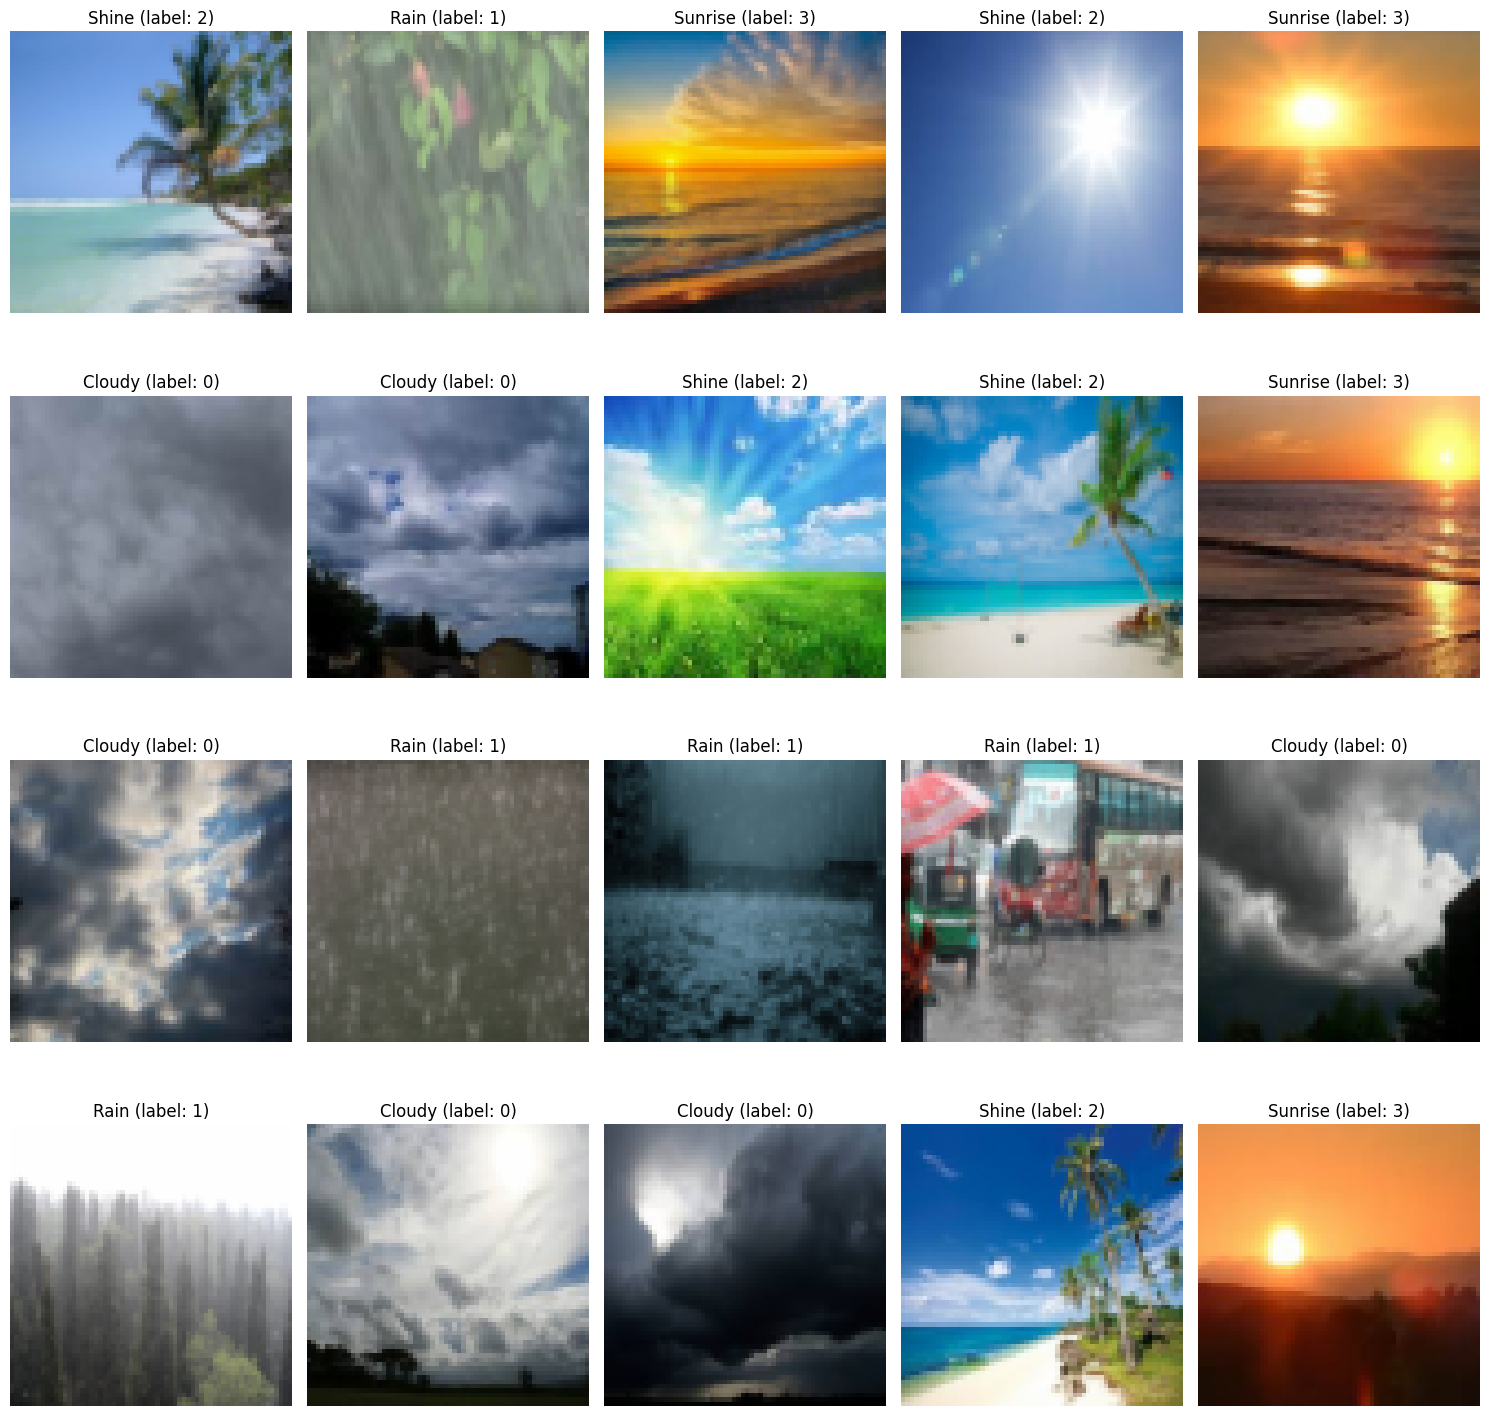

In [6]:
random_indices = np.random.choice(len(images), size=20, replace=False)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(images[idx])
    plt.title(f"{classes[labels[idx]]} (label: {labels[idx]})")
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Data Splitting**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=42)

## **Augmentation**

In [8]:
import numpy as np
from skimage.transform import rotate, rescale, resize
from skimage.exposure import adjust_gamma, adjust_sigmoid
from skimage.color import rgb2hsv, hsv2rgb
from tqdm import tqdm

augmentation_factor = 5

# Function to apply data augmentation on the training set
def augment_images(images, labels, augmentation_factor):
    augmented_images = []
    augmented_labels = []

    for i in tqdm(range(len(images)), desc='Augmenting training images'):
        image = images[i]
        label = labels[i]

        augmented_images.append(image)
        augmented_labels.append(label)

        for _ in range(augmentation_factor):
            augmented_image = image.copy()

            # Horizontal and Vertical Flips
            if np.random.rand() < 0.5:
                augmented_image = np.fliplr(augmented_image)
            if np.random.rand() < 0.5:
                augmented_image = np.flipud(augmented_image)

            # Brightness and Contrast Adjustments
            augmented_image = adjust_gamma(augmented_image, gamma=np.random.uniform(0.7, 1.3))
            augmented_image = adjust_sigmoid(augmented_image, cutoff=np.random.uniform(0.3, 0.7))

            hsv_image = rgb2hsv(augmented_image)
            hsv_image[:, :, 0] += np.random.uniform(-0.05, 0.05)  # Hue variation
            hsv_image[:, :, 1] *= np.random.uniform(0.8, 1.2)      # Saturation variation
            augmented_image = hsv2rgb(hsv_image)

            augmented_image = resize(augmented_image, (img_width, img_height))

            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

augmented_X_train, augmented_y_train = augment_images(X_train, y_train, augmentation_factor)

final_X_train = np.concatenate((X_train, augmented_X_train), axis=0)
final_y_train = np.concatenate((y_train, augmented_y_train), axis=0)

print("Augmentation completed")

Augmenting training images: 100%|██████████| 901/901 [00:14<00:00, 61.04it/s]


Augmentation completed


In [9]:
print(X_train.shape)
print(final_X_train.shape)
print(y_train.shape)
print(final_y_train.shape)

(901, 64, 64, 3)
(6307, 64, 64, 3)
(901,)
(6307,)


## **Model Architecture - basic CNN**

In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])



model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,274,180 (4.86 MB)

 Trainable params: 1,274,180 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

## **Hyperparameters for training** 

In [11]:
epochs = 50
batch_size = 100
# callback for early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

## **Model Training**

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(final_X_train, final_y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_split=0.2, callbacks=[early_stop])
print("Training completed")

Epoch 1/50


2024-07-26 16:50:32.981247: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 328: 5.6489, expected 4.98249
2024-07-26 16:50:32.981305: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 329: 5.27113, expected 4.60471
2024-07-26 16:50:32.981315: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 427: 5.63763, expected 4.97121
2024-07-26 16:50:32.981323: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 428: 5.59986, expected 4.93345
2024-07-26 16:50:32.981331: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 489: 5.53772, expected 4.87131
2024-07-26 16:50:32.981339: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 551: 5.6466, expected 4.98018
2024-07-26 16:50:32.981360: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1232: 5.61392, expected 4.9475
2024-07-26 16:50:32.981368: E external/loca

21/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4685 - loss: 1.1601

I0000 00:00:1722012636.278368      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722012636.297870      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5654 - loss: 0.9839

2024-07-26 16:50:37.358785: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19220: 7.45692, expected 6.54118
2024-07-26 16:50:37.358853: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19221: 6.70228, expected 5.78654
2024-07-26 16:50:37.358862: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19222: 6.80187, expected 5.88613
2024-07-26 16:50:37.358870: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19223: 6.66891, expected 5.75317
2024-07-26 16:50:37.358878: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19224: 7.33075, expected 6.41501
2024-07-26 16:50:37.358886: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19226: 7.24996, expected 6.33422
2024-07-26 16:50:37.358894: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19227: 6.73882, expected 5.82309
2024-07-26 16:50:37.358901:

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5700 - loss: 0.9754

W0000 00:00:1722012640.231462      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-07-26 16:50:40.402781: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 41: 6.36735, expected 5.62138
2024-07-26 16:50:40.402847: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 53: 6.2543, expected 5.50833
2024-07-26 16:50:40.402857: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 69: 5.6686, expected 4.92264
2024-07-26 16:50:40.402865: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 114: 6.36507, expected 5.6191
2024-07-26 16:50:40.402873: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 115: 6.43538, expected 5.68941
2024-07-26 16:50:40.402881: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 130: 5.74785, expected 5.00188
2024-07-26 16:50:40.402889: E external/local_xla/xla/servic

51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.5721 - loss: 0.9714 - val_accuracy: 0.8384 - val_loss: 0.4660
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8212 - loss: 0.5007 - val_accuracy: 0.8399 - val_loss: 0.4183
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8478 - loss: 0.4120 - val_accuracy: 0.8851 - val_loss: 0.3201
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8755 - loss: 0.3367 - val_accuracy: 0.9017 - val_loss: 0.2821
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8906 - loss: 0.2995 - val_accuracy: 0.8930 - val_loss: 0.3300
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9107 - loss: 0.2370 - val_accuracy: 0.9097 - val_loss: 0.2717
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9121 - loss: 0.2305 - val_accuracy: 0.8859 - val_loss: 0.3279
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9320 - loss: 0.1893 - val_accuracy: 0.9010 - val_loss: 0.3003
E

## **Model evaluation**

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

y_score = model.predict(X_test)
print("Testing completed")

2024-07-26 16:50:54.637942: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 6.39927, expected 5.58886
2024-07-26 16:50:54.637997: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.92185, expected 5.11143
2024-07-26 16:50:54.638007: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.99669, expected 5.18628
2024-07-26 16:50:54.638014: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.48891, expected 5.6785
2024-07-26 16:50:54.638022: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.18882, expected 5.37841
2024-07-26 16:50:54.638030: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.76108, expected 5.95067
2024-07-26 16:50:54.638037: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.21291, expected 5.4025
2024-07-26 16:50:54.638045: E external/local_xla/xla/serv

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9593 - loss: 0.1054


W0000 00:00:1722012655.756667      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test accuracy: 0.9690
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Testing completed


W0000 00:00:1722012656.689623      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## **Define needed variables for plotting**

In [14]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

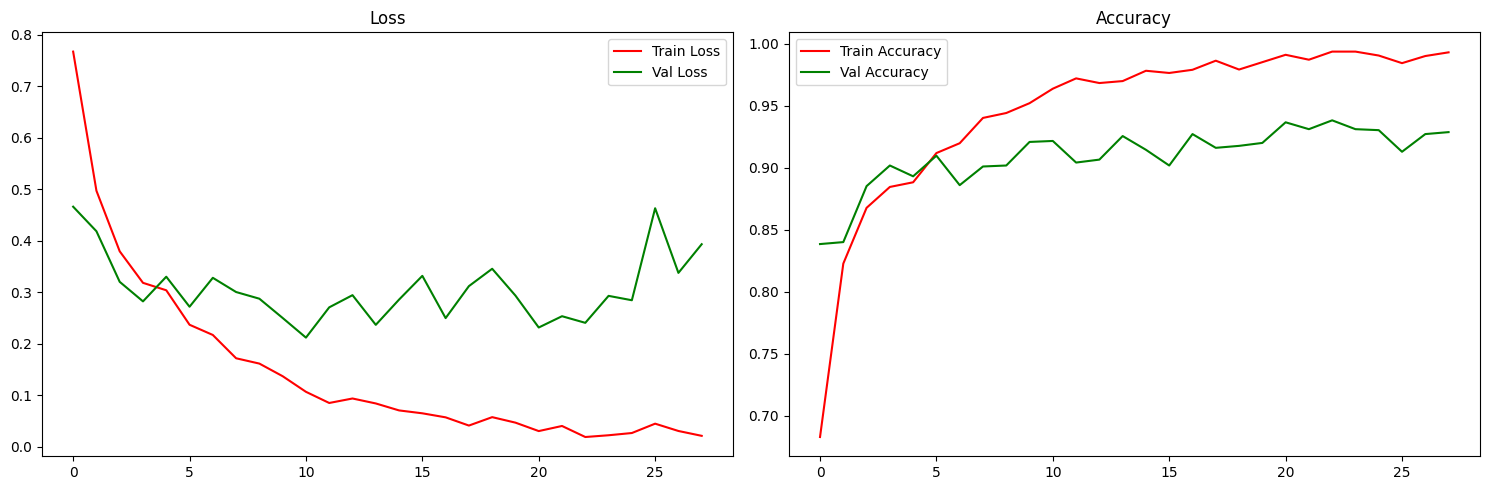

In [15]:
plt.figure(figsize=(15, 5))
plt.style.use('default')

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'r', label = 'Train Loss')
plt.plot(history.history['val_loss'][:epochs], 'g', label = 'Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'r', label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'][:epochs], 'g', label = 'Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

## **Confusion Matrix**

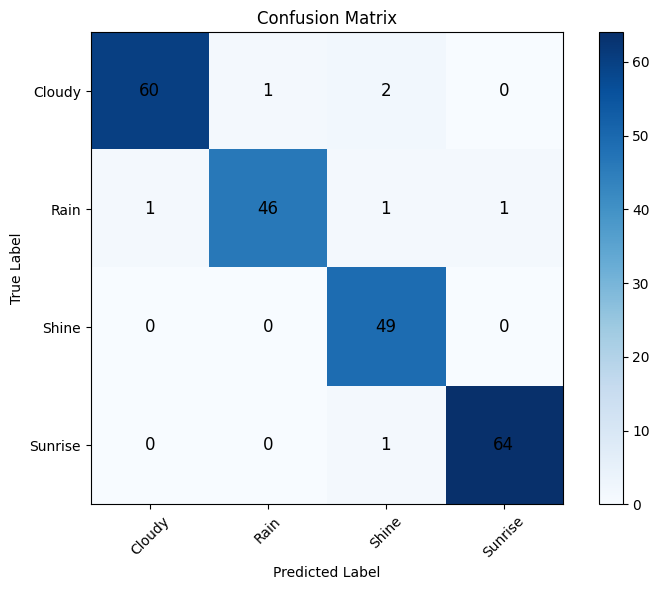

In [16]:
predicted_labels = np.argmax(y_score, axis=1)
conf_matrix = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(8, 6))
plt.style.use('default')
plt.title("Confusion Matrix")
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## **Test random pics**

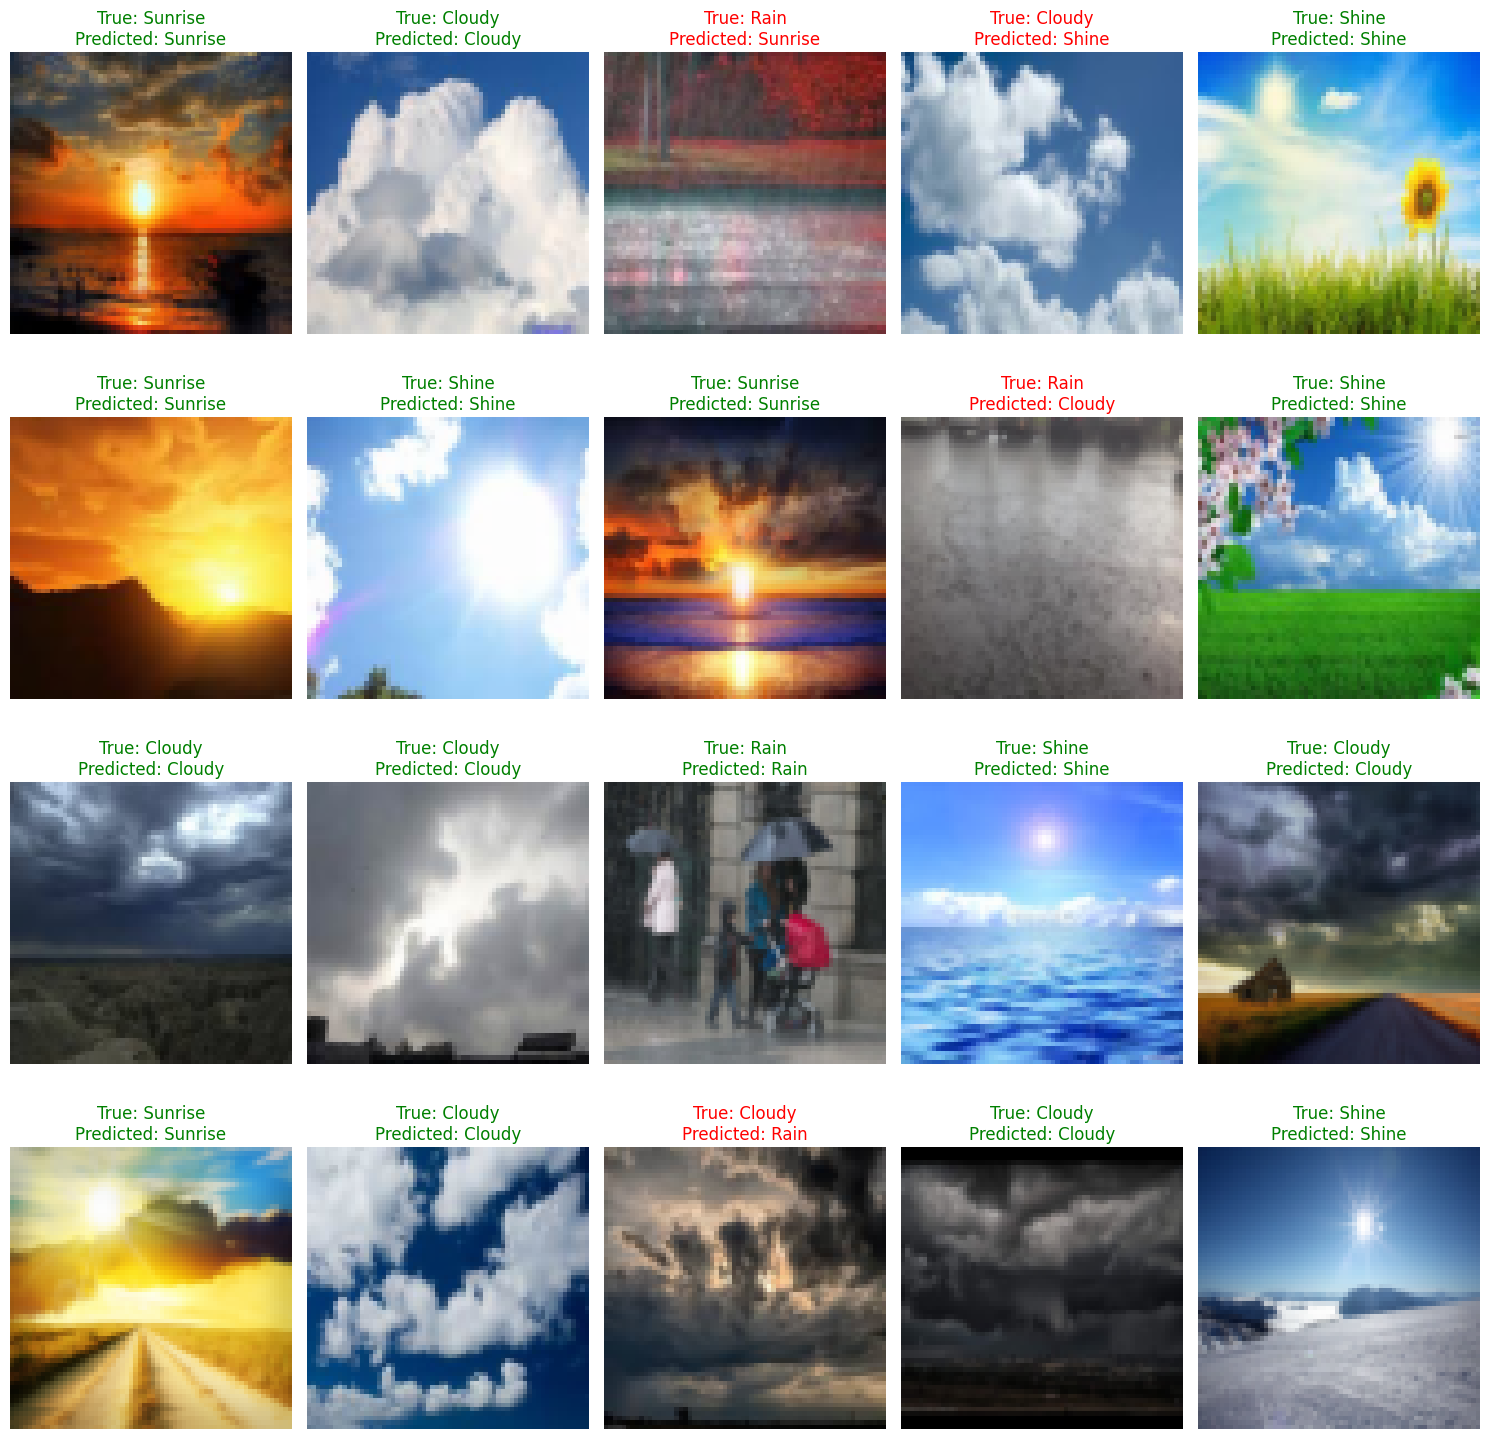

In [17]:
num_samples = 20
rows = 4
wrong_predictions_indices = [idx for idx, (true_label, predicted_label) in enumerate(zip(y_test, predicted_labels)) 
                             if true_label != predicted_label]

random_indices = random.sample(range(len(X_test)), num_samples - rows)
random_wrong_indices = random.sample(wrong_predictions_indices, 4)
random_indices.extend(random_wrong_indices)
random_indices = sorted(random_indices)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    plt.subplot(rows, int(num_samples / rows), i + 1)
    plt.imshow(X_test[idx])
    true_label = y_test[idx]
    true_class = classes[true_label]
    predicted_class = classes[predicted_labels[idx]]
    
    # color-code the correct predictions 
    if true_class == predicted_class:
        predicted_color = 'green'
    else:
        predicted_color = 'red'
    plt.title(f'True: {true_class}\nPredicted: {predicted_class}', color=predicted_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Comparing Models**

### **1. Select Pre-trained Models**
We'll use VGG16, ResNet50, and MobileNetV2 for this task. These models are well-suited for image classification tasks and can be fine-tuned.

### **2. Load Pre-trained Models**

In [18]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def build_pretrained_model(base_model, input_shape=(img_width, img_height, channels), num_classes=len(classes)):
    # Create a custom input layer
    input_layer = Input(shape=input_shape)
    
    # Use the base model for feature extraction
    base_model_output = base_model(input_layer, training=False)
    
    # Add custom classification head
    x = GlobalAveragePooling2D()(base_model_output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    # Create a new model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# Load pre-trained models without the top classification layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, channels))
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, channels))
mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, channels))

# Build models with custom classification heads
vgg16_model = build_pretrained_model(vgg16_base)
resnet50_model = build_pretrained_model(resnet50_base)
mobilenetv2_model = build_pretrained_model(mobilenetv2_base)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### **3. Fine-tune the Models**

In [19]:
# Freeze the base layers
vgg16_base.trainable = False
resnet50_base.trainable = False
mobilenetv2_base.trainable = False

# Compile models
models = {
    #'Basic CNN': model,
    'VGG16': vgg16_model,
    'ResNet50': resnet50_model,
    'MobileNetV2': mobilenetv2_model
}

for name, model in models.items():
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### **4. Compile and Train the Models**

In [20]:
histories = {}

for name, model in models.items():
    print(f"Training {name} model...")
    history = model.fit(final_X_train, final_y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=[early_stop])
    histories[name] = history
    print(f"{name} training completed.")

Training VGG16 model...
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 193ms/step - accuracy: 0.6008 - loss: 0.9467 - val_accuracy: 0.8320 - val_loss: 0.4350
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8607 - loss: 0.3977 - val_accuracy: 0.8685 - val_loss: 0.3719
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8877 - loss: 0.3057 - val_accuracy: 0.8732 - val_loss: 0.3431
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9102 - loss: 0.2702 - val_accuracy: 0.8827 - val_loss: 0.3133
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9288 - loss: 0.2176 - val_accuracy: 0.8803 - val_loss: 0.3191
VGG16 training completed.
Training ResNet50 model...
Epoch 1/50
10/51 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2442 - loss: 1.6043

W0000 00:00:1722012702.908773      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2878 - loss: 1.4817

W0000 00:00:1722012712.895047      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 267ms/step - accuracy: 0.2885 - loss: 1.4802 - val_accuracy: 0.3859 - val_loss: 1.3051
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4038 - loss: 1.2860 - val_accuracy: 0.4604 - val_loss: 1.2482
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4493 - loss: 1.2345 - val_accuracy: 0.4842 - val_loss: 1.2030
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4771 - loss: 1.1862 - val_accuracy: 0.5190 - val_loss: 1.1769
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5097 - loss: 1.1478 - val_accuracy: 0.5380 - val_loss: 1.1411
ResNet50 training completed.
Training MobileNetV2 model...
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 242ms/step - accuracy: 0.6314 - loss: 0.9825 - val_accuracy: 0.8320 - val_loss: 0.4256
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9006 - loss: 0.2889 - val_accuracy: 0.8724 - val_loss: 0.3417
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accura

### **5. Evaluate and Compare**

In [21]:
results = {}
modelss = {
    'Basic CNN': model,
    'VGG16': vgg16_model,
    'ResNet50': resnet50_model,
    'MobileNetV2': mobilenetv2_model
}
for name, model in modelss.items():
    print(f"Evaluating {name} model...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    results[name] = test_accuracy
    print(f"{name} Test Accuracy: {test_accuracy:.4f}")

Evaluating Basic CNN model...
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 377ms/step - accuracy: 0.8288 - loss: 0.4140
Basic CNN Test Accuracy: 0.8496
Evaluating VGG16 model...
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.6979 - loss: 2.0614
VGG16 Test Accuracy: 0.6991
Evaluating ResNet50 model...
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - accuracy: 0.3112 - loss: 1.3509
ResNet50 Test Accuracy: 0.3097
Evaluating MobileNetV2 model...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8288 - loss: 0.4140 
MobileNetV2 Test Accuracy: 0.8496


#### **Plot Training and Validation Metrics**

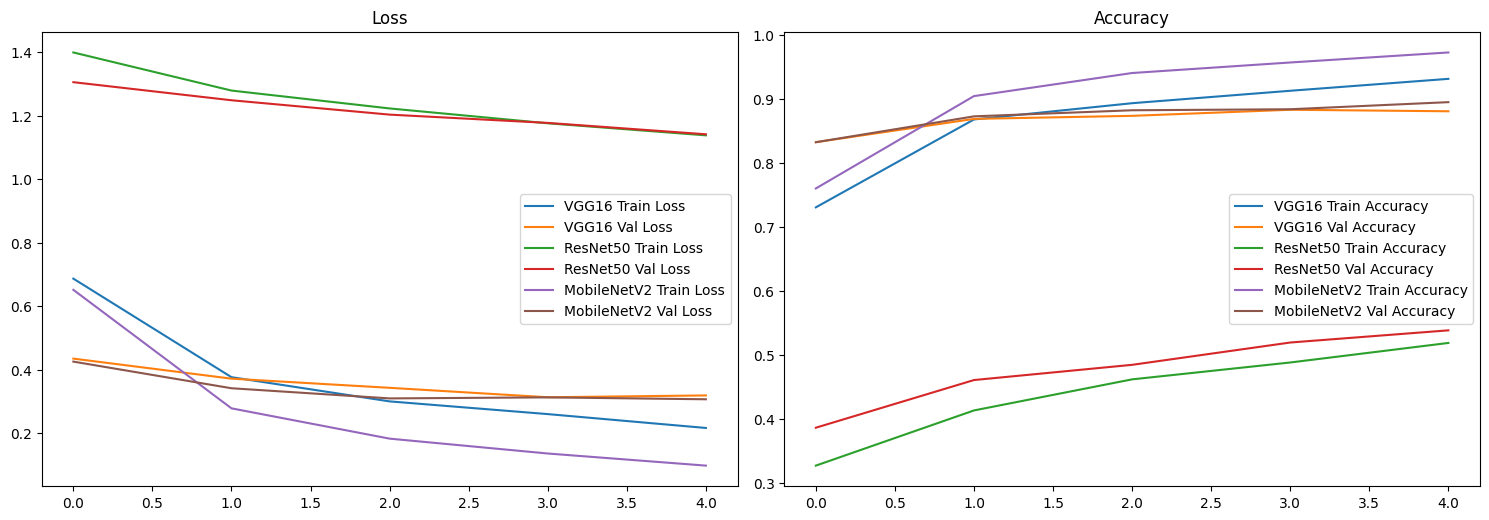

In [22]:
plt.figure(figsize=(15, 10))

for name, history in histories.items():
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label=f'{name} Train Loss')
    plt.plot(history.history['val_loss'], label=f'{name} Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label=f'{name} Train Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{name} Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

#### **Confusion Matrix for Each Model**

Confusion Matrix for VGG16 model:
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


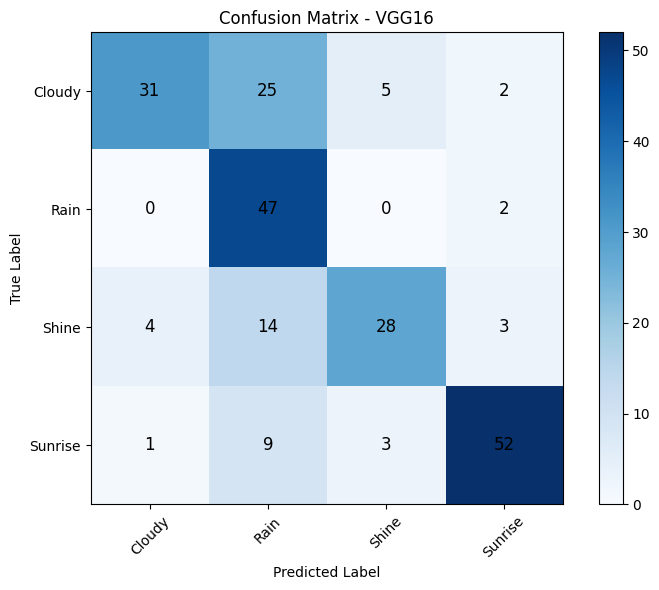

Confusion Matrix for ResNet50 model:
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 517ms/step


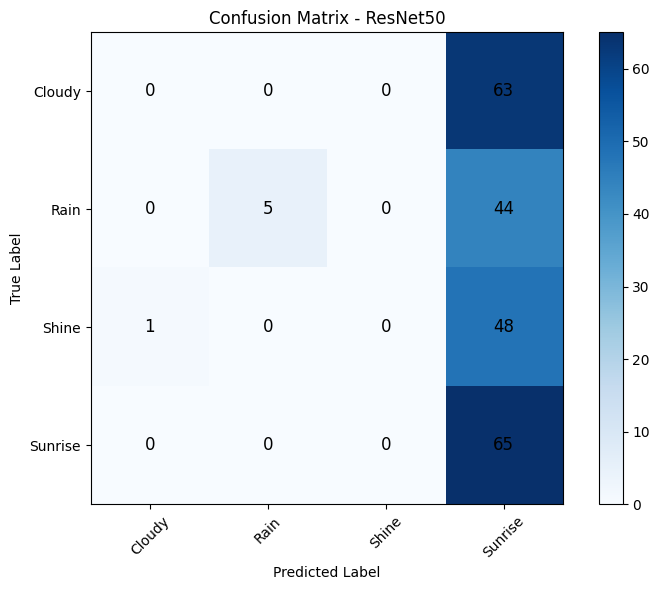

Confusion Matrix for MobileNetV2 model:
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 410ms/step


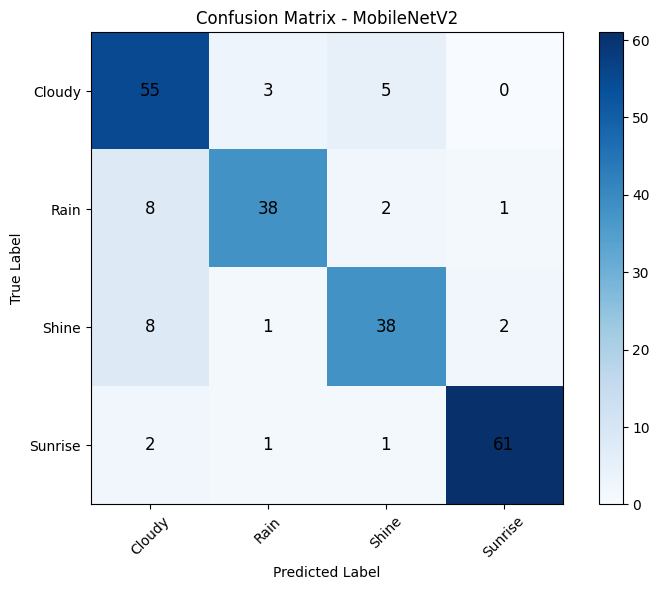

In [23]:
for name, model in models.items():
    print(f"Confusion Matrix for {name} model:")
    y_pred = model.predict(X_test)
    predicted_labels = np.argmax(y_pred, axis=1)
    conf_matrix = confusion_matrix(y_test, predicted_labels)

    plt.figure(figsize=(8, 6))
    plt.title(f"Confusion Matrix - {name}")
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black', fontsize=12)

    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

### **Fine-tune Pre-trained Model**

In [24]:
# Unfreeze the last few layers for fine-tuning
vgg16_base.trainable = True
for layer in vgg16_base.layers[:-4]:
    layer.trainable = False

# Recompile and retrain
vgg16_model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg16_fine_tune_history = vgg16_model.fit(final_X_train, final_y_train,
                                          epochs=epochs,
                                          batch_size=batch_size,
                                          validation_split=0.2,
                                          callbacks=[early_stop])

# Update history
histories['VGG16 (fine-tuned)'] = vgg16_fine_tune_history

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.8736 - loss: 0.3648 - val_accuracy: 0.9358 - val_loss: 0.1811
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9684 - loss: 0.0918 - val_accuracy: 0.9398 - val_loss: 0.1601
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9856 - loss: 0.0449 - val_accuracy: 0.9532 - val_loss: 0.1610
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9948 - loss: 0.0184 - val_accuracy: 0.9517 - val_loss: 0.1827
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9955 - loss: 0.0134 - val_accuracy: 0.9350 - val_loss: 0.2423
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9910 - loss: 0.0352 - val_accuracy: 0.9493 - val_loss: 0.1574
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9958 - loss: 0.0128 - val_accuracy: 0.9398 - val_loss: 0.2270
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9959 - loss: 0.0137 - val_accuracy: 0.9461 -

Confusion Matrix for VGG16 model:
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


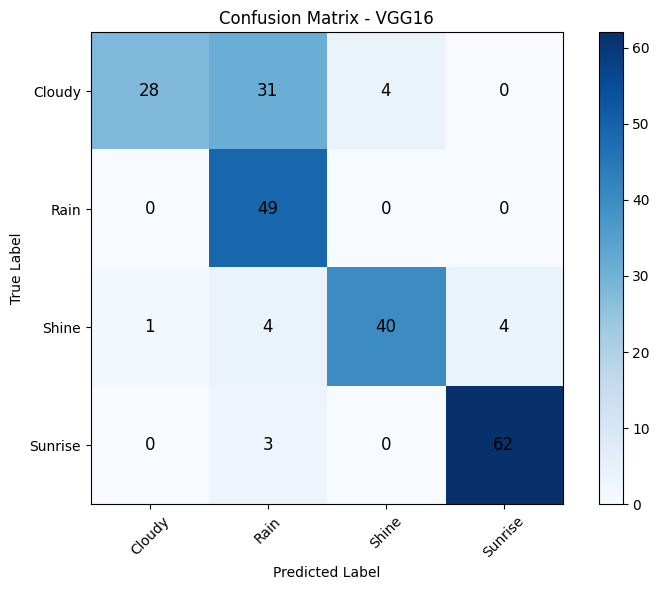

Confusion Matrix for ResNet50 model:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


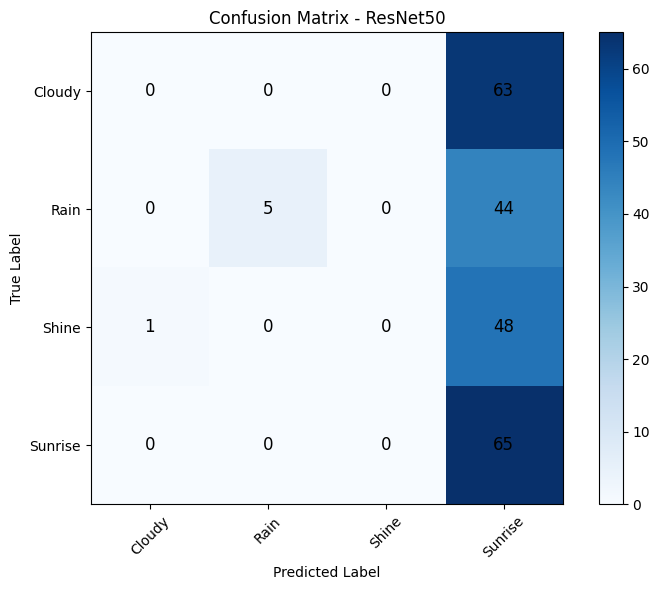

Confusion Matrix for MobileNetV2 model:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


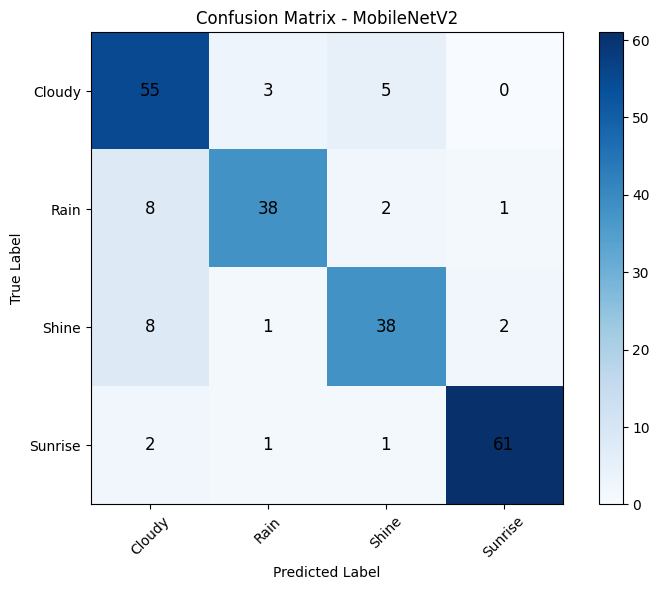

In [25]:
for name, model in models.items():
    print(f"Confusion Matrix for {name} model:")
    y_pred = model.predict(X_test)
    predicted_labels = np.argmax(y_pred, axis=1)
    conf_matrix = confusion_matrix(y_test, predicted_labels)

    plt.figure(figsize=(8, 6))
    plt.title(f"Confusion Matrix - {name}")
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black', fontsize=12)

    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()